# Venue options in the Safest and Most Dangerous Neighborhoods of Atlanta


In this notebook, I compared the crime rate between neighborhoods in the city of Atlanta, in a span of 10 years (2009-2019). Crime per year, crime per day of the week, most common crimes and most dangerous and safest neighborhoods were some of the points analyzed below. 

After that, I analyzed what kind of venues are most common in the most dangerous and the safest neighborhoods, using the Foursquare API. 

Then intent of this analysis is to provide turists or locals options of venues to visit in less dangerous neighborhoods.  

Let's begin with the imports.

In [1]:
import requests # to make requests to the Foursquare website
import json # to deal with json files

import folium # to plot maps
import pandas as pd # to open the dataframe
import geopandas as gpd # to open a geodataframe
import numpy as np # to deal with array operations
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting 

from geopy.geocoders import Nominatim # for geocoding

Next, I opened the dataset. This was originally extracted from the [Atlanta Police Department](https://www.atlantapd.org/i-want-to/crime-data-downloads), and contains data from crime occurences for the past 10 years. I selected just especific columns I wanted to work with and saved in this [CSV file](https://github.com/anaflvss/Coursera-Capstone/blob/master/data/crime_atlanta_2009_to_2019.csv).

In [2]:
crime_rate_atl_original = pd.read_csv('../Coursera-Capstone/data/crime_atlanta_2009_to_2019.csv')
crime_rate_atl_original.head()

,Report Number,Occur Date,Location,UCR Literal,Neighborhood,Latitude,Longitude
0,90010930,2009-01-01,2841 GREENBRIAR PKWY,LARCENY-NON VEHICLE,Greenbriar,33.68845,-84.49328
1,90011083,2009-01-01,12 BROAD ST SW,LARCENY-NON VEHICLE,Downtown,33.75320,-84.39201
2,90011208,2009-01-01,3500 MARTIN L KING JR DR SW,LARCENY-NON VEHICLE,Adamsville,33.75735,-84.50282
3,90011218,2009-01-01,3393 PEACHTREE RD NE,LARCENY-NON VEHICLE,Lenox,33.84676,-84.36212
4,90011289,2009-01-01,2841 GREENBRIAR PKWY SW,LARCENY-NON VEHICLE,Greenbriar,33.68677,-84.49773


## 1. Data Cleaning
Let's analyze the structure of the dataframe.

In [3]:
crime_rate_atl_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342914 entries, 0 to 342913
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Report Number  342914 non-null  int64  
 1   Occur Date     342914 non-null  object 
 2   Location       342912 non-null  object 
 3   UCR Literal    342914 non-null  object 
 4   Neighborhood   330551 non-null  object 
 5   Latitude       342914 non-null  float64
 6   Longitude      342914 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 18.3+ MB


* The are some points that needed to be corrected. First, I standandized the column names, removing spaces and capital letters.

In [4]:
crime_rate_atl_original.columns = crime_rate_atl_original.columns.str.lower()\
                                                         .str.replace(' ', '_')

* It's also possible to see that the dataframe has 342914 entries. Since is a big dataset, it's important to pay attention to duplicated rows. 

 There were a few in this dataframe, so I removed them all.

In [5]:
crime_rate_atl_original[crime_rate_atl_original.duplicated()].shape

(169, 7)

In [6]:
crime_rate_atl_original.drop_duplicates(keep='first', inplace=True, ignore_index=True)

* Next, it's time to check for missing data.

In [7]:
crime_rate_atl_original.isnull().sum()

report_number        0
occur_date           0
location             2
ucr_literal          0
neighborhood     12357
latitude             0
longitude            0
dtype: int64

* There were about 12300 rows with the neighborhood missing. Altough this represents a small fraction of the dataset, it could represent a difference in what neighborhoods were more dangerous or safer. So I used reverse geocoding to find those neighborhoods as shown in the code below. The result was saved in this [CSV file](https://github.com/anaflvss/Coursera-Capstone/blob/master/data/missing_neighborhoods.csv).

````python
missing_neighborhoods = pd.read_csv('../Coursera-Capstone/missing_neighborhoods.csv')
locator = Nominatim(user_agent='at_explorer')

for i in missing_neighborhoods.index.tolist():
    coordinate = missing_neighborhoods.latitude[i], missing_neighborhoods.longitude[i]
    location = locator.reverse(coordinate)
    local = location.raw
    
    try:
        missing_neighborhoods.loc[i, 'neighborhood'] = local['address']['neighbourhood']
    except(KeyError):
        missing_neighborhoods.loc[i, 'neighborhood'] = 'None'
 ````
 
 However, the search revealed that these rows didn't refer to a neighborhood specifically. So, they were dropped from the data.

In [8]:
# I created a new dataframe without the null rows.
missing_nbgd_rows = crime_rate_atl_original[crime_rate_atl_original.neighborhood.isnull() == True].index
crime_rate_atl = crime_rate_atl_original.drop(missing_nbgd_rows, axis=0).copy()

* Another problem in the dataset is that ``occur_date`` has the wrong type, it should be datetime. 

 I fixed that and also sorted the data, so it has a chronological order.

In [9]:
crime_rate_atl['occur_date'] = pd.to_datetime(crime_rate_atl['occur_date'])
crime_rate_atl.sort_values('occur_date', inplace=True)

* The code above showed that there were some crimes that occured previous to 2009 in the dataframe. I created a new column with the year of each crime to identify them and then, drop those rows.

In [10]:
crime_rate_atl['year'] = crime_rate_atl['occur_date'].dt.year # new column
crime_rate_atl = crime_rate_atl[crime_rate_atl.year >= 2009]

In [11]:
# Now, I reset the index. 
crime_rate_atl.reset_index(drop=True, inplace=True)

* Finally, I used the ``occur_date`` column to find in what day of the week the crimes has occured.

In [12]:
week_day = [crime_rate_atl['occur_date'][i].day_name() for i in range(len(crime_rate_atl))]
crime_rate_atl.insert(2, 'week_day', week_day)

* It's possible to check the new shape of the dataframe and the columns dtype below.

In [13]:
crime_rate_atl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330003 entries, 0 to 330002
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   report_number  330003 non-null  int64         
 1   occur_date     330003 non-null  datetime64[ns]
 2   week_day       330003 non-null  object        
 3   location       330001 non-null  object        
 4   ucr_literal    330003 non-null  object        
 5   neighborhood   330003 non-null  object        
 6   latitude       330003 non-null  float64       
 7   longitude      330003 non-null  float64       
 8   year           330003 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 22.7+ MB


In [14]:
crime_rate_atl.head()

,report_number,occur_date,week_day,location,ucr_literal,neighborhood,latitude,longitude,year
0,90020008,2009-01-01,Thursday,2762 VINEYARDS DR SE,AUTO THEFT,Rosedale Heights,33.67957,-84.36996,2009
1,90050755,2009-01-01,Thursday,1466 PINE ST NW,LARCENY-FROM VEHICLE,Loring Heights,33.79520,-84.40121,2009
2,90010159,2009-01-01,Thursday,BUCKEAD AVE/GRANDVIEW AVE,ROBBERY-PEDESTRIAN,Buckhead Village,33.83752,-84.37574,2009
3,90010726,2009-01-01,Thursday,160 JOHN WESLEY DOBBS AVE,ROBBERY-PEDESTRIAN,Downtown,33.75734,-84.38256,2009
4,90010930,2009-01-01,Thursday,2841 GREENBRIAR PKWY,LARCENY-NON VEHICLE,Greenbriar,33.68845,-84.49328,2009


## 2. Data Analysis

First, let's check how many neighborhoods there are in the Atlanta.

In [15]:
crime_rate_atl.neighborhood.nunique()

243

* The number above matches the information in [Wikipedia](https://en.wikipedia.org/wiki/Neighborhoods_in_Atlanta).

 Next, i analyzed the data using some plots. This first plot represents the top 20 most dangerous neighborhoods, according to our dataframe. 

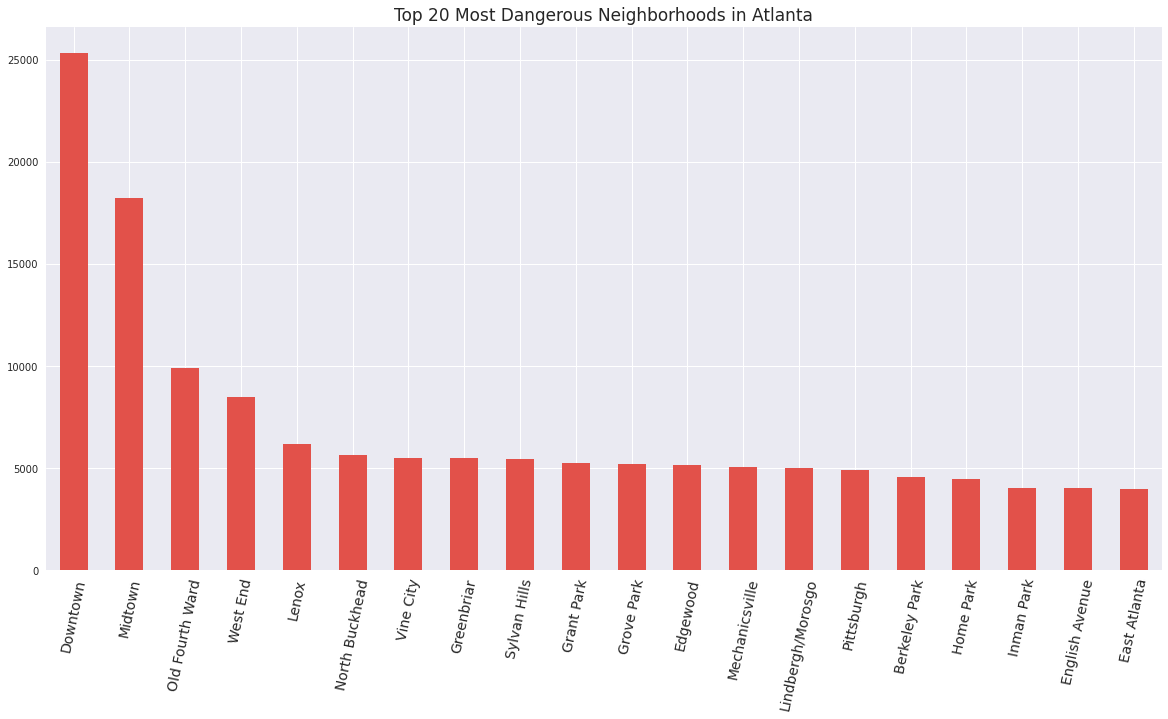

In [16]:
plt.style.use('seaborn')
sns.set_palette('Spectral')
crime_rate_atl.neighborhood.value_counts()\
                           .nlargest(20)\
                           .plot(kind='bar', figsize=(20,10))
plt.title('Top 20 Most Dangerous Neighborhoods in Atlanta', fontsize=17)
plt.xticks(rotation=78, fontsize=14)
plt.show()

* The second one it's about the top 20 safest neighborhoods, according to the dataframe.

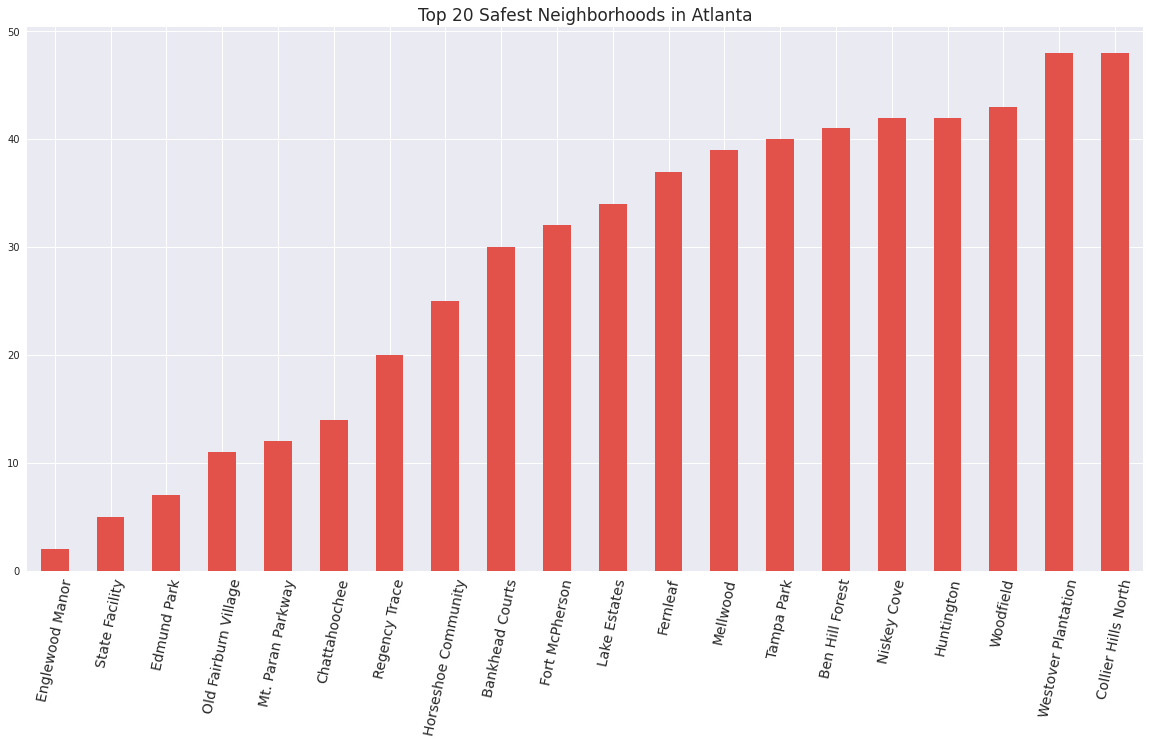

In [17]:
crime_rate_atl.neighborhood.value_counts()\
                           .nsmallest(20)\
                           .plot(kind='bar', figsize=(20,10))
plt.title('Top 20 Safest Neighborhoods in Atlanta', fontsize=17)
plt.xticks(rotation=78, fontsize=14)
plt.show()

* Next, it's the frequency of each type of crime over 10 years.

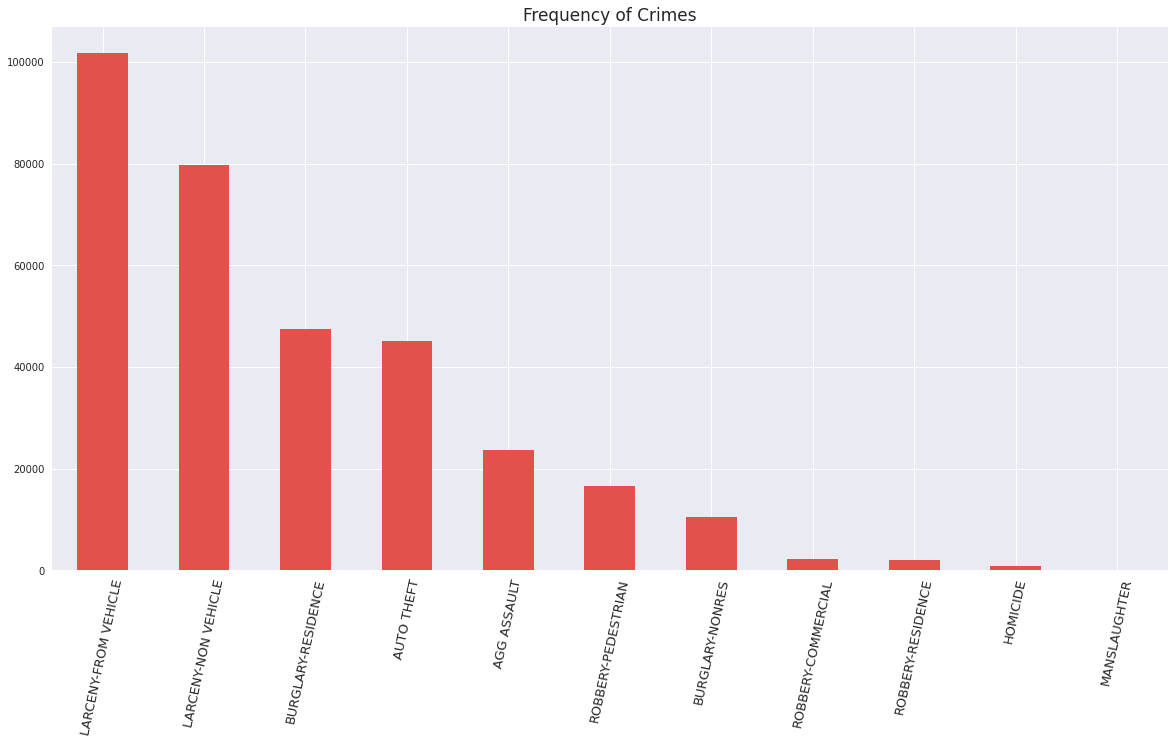

In [18]:
crime_rate_atl.ucr_literal.value_counts().plot(kind='bar', figsize=(20,10))
plt.title('Frequency of Crimes', fontsize=17)
plt.xticks(rotation=78, fontsize=13)
plt.show()

* I also plotted the number of crimes per day of the week;

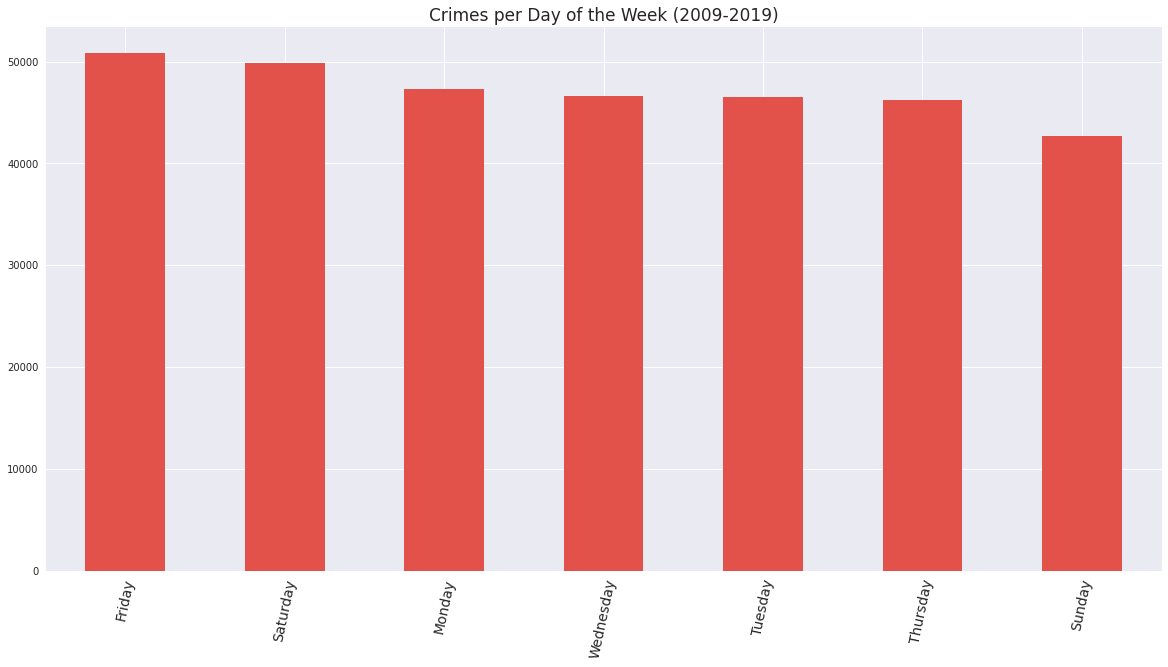

In [19]:
crime_rate_atl.week_day.value_counts().plot(kind='bar', figsize=(20,10))
plt.title('Crimes per Day of the Week (2009-2019)', fontsize=17)
plt.xticks(rotation=78, fontsize=14)
plt.show()

* Crimes per month over 10 years;

In [20]:
crime_rate_atl['occur_date'].dt.month_name().value_counts()

July         30444
August       29615
May          29199
June         29146
October      28986
December     28555
September    28318
November     27441
January      26653
April        26196
March        24069
February     21381
Name: occur_date, dtype: int64

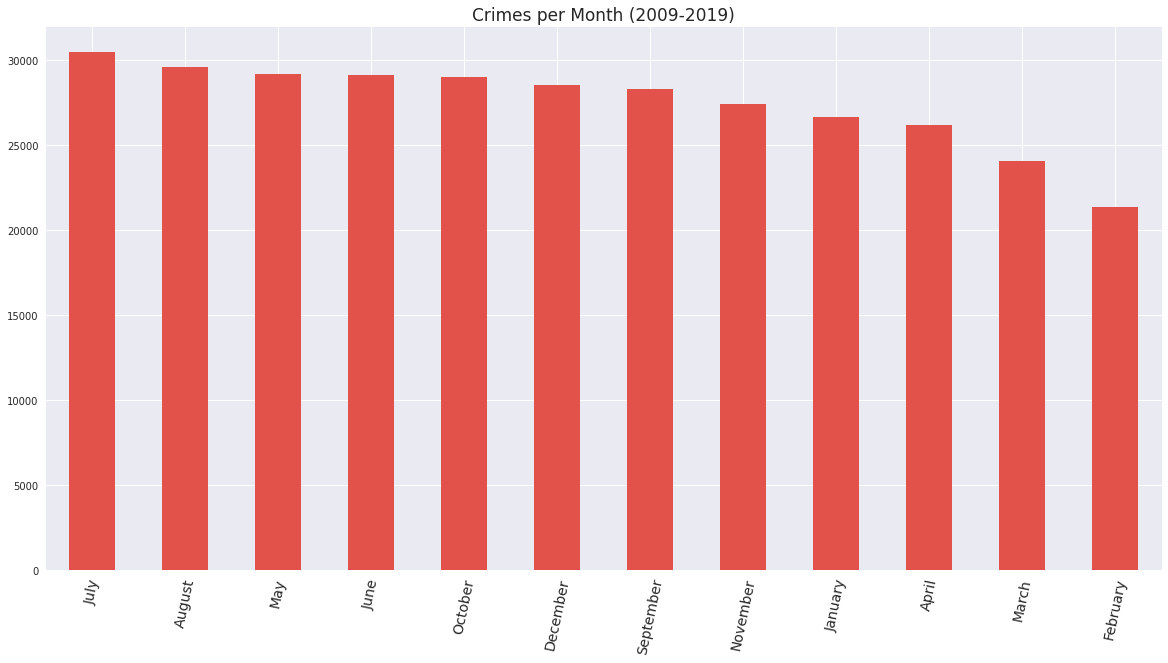

In [21]:
crime_rate_atl['occur_date'].dt.month_name()\
                               .value_counts()\
                               .plot(kind='bar', figsize=(20,10))
plt.title('Crimes per Month (2009-2019)', fontsize=17)
plt.xticks(rotation=78, fontsize=14)
plt.show()

* And finally, I plotted the crime rate per year.

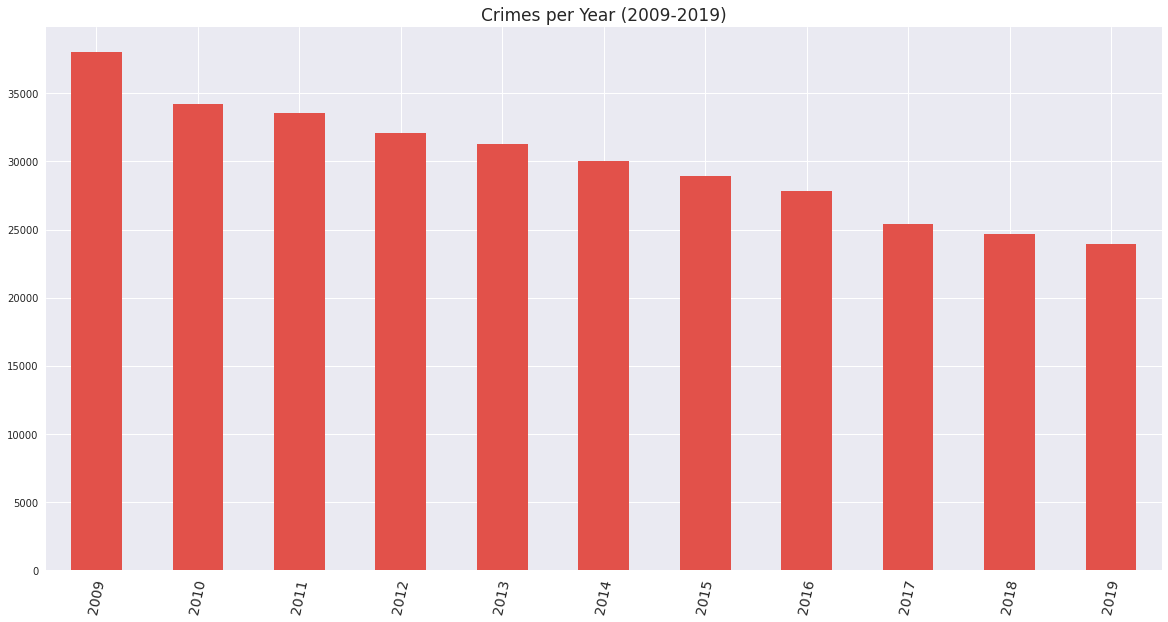

In [22]:
crime_rate_atl.year.value_counts().plot(kind='bar', figsize=(20,10))
plt.title('Crimes per Year (2009-2019)', fontsize=17)
plt.xticks(rotation=78, fontsize=14)
plt.show()

* The table below shows the frequency of each of the crimes observed in the dataframe per the top 20 most dangerous neighborhoods.

In [23]:
crimes_per_nbhd = pd.crosstab(crime_rate_atl.neighborhood, 
                              crime_rate_atl.ucr_literal) 
                              

crime_rate_top_20 = crime_rate_atl.neighborhood.value_counts()\
                                               .nlargest(20)\
                                               .index.tolist()
crime_rate_bottom_20 = crime_rate_atl.neighborhood.value_counts()\
                                                  .nsmallest(20)\
                                                  .index.tolist()

top_20_crosstab = crimes_per_nbhd[crimes_per_nbhd.index.isin(crime_rate_top_20)]
top_20_crosstab

ucr_literal,AGG ASSAULT,AUTO THEFT,BURGLARY-NONRES,BURGLARY-RESIDENCE,HOMICIDE,LARCENY-FROM VEHICLE,LARCENY-NON VEHICLE,MANSLAUGHTER,ROBBERY-COMMERCIAL,ROBBERY-PEDESTRIAN,ROBBERY-RESIDENCE
neighborhood,,,,,,,,,,,
Berkeley Park,45,249,114,131,0,1155,2794,0,33,57,2
Downtown,1477,2330,481,429,41,11048,7959,0,139,1389,57
East Atlanta,184,565,142,877,10,1206,647,0,58,253,29
Edgewood,231,479,94,533,3,834,2761,0,43,179,14
English Avenue,579,506,177,646,38,862,851,0,26,301,53
Grant Park,212,890,178,600,3,2294,869,0,30,183,25
Greenbriar,248,931,176,541,8,1503,1766,0,48,237,26
Grove Park,666,745,190,1245,35,869,1022,0,36,365,44
Home Park,108,455,159,227,2,2674,645,0,15,159,10


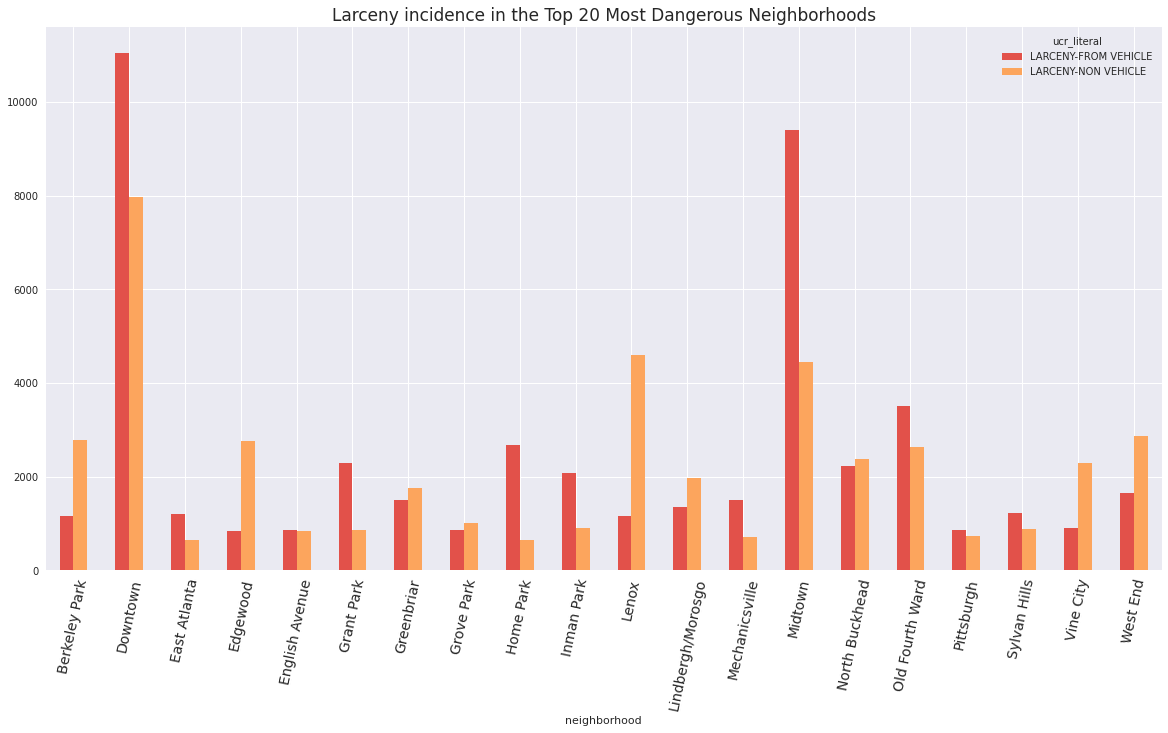

In [24]:
sns.set_palette('Spectral')

top_20_crosstab.loc[:, 'LARCENY-FROM VEHICLE':'LARCENY-NON VEHICLE']\
               .plot(kind='bar', figsize=(20,10))
plt.title('Larceny incidence in the Top 20 Most Dangerous Neighborhoods', fontsize=17)
plt.xticks(rotation=78, fontsize=14)
plt.show()

## 3. Coordinates

* To plot a map, it's necessary to use the coordinates. This dataframe already has latitude and longitude columns. Since the same neighborhoods appears many times, I chose one of the coordinates for each neighborhood.

 Finally, I created a new dataframe containing only the neighborhood names and coordinates.

In [25]:
coordinates = crime_rate_atl.groupby('neighborhood')[['neighborhood', 'latitude', 'longitude']]\
                            .first()\
                            .reset_index(drop=True)

coordinates

,neighborhood,latitude,longitude
0,Adair Park,33.72737,-84.41190
1,Adams Park,33.70602,-84.45942
2,Adamsville,33.75735,-84.50282
3,Almond Park,33.78752,-84.45789
4,Amal Heights,33.70943,-84.39839
...,...,...,...
238,Wilson Mill Meadows,33.75174,-84.52101
239,Wisteria Gardens,33.75470,-84.51365
240,Woodfield,33.82287,-84.41065
241,Woodland Hills,33.72438,-84.35184


In [26]:
coordinates.shape

(243, 3)

* Also, I found the coordinates of Atlanta, which will be useful to plot the map.

In [27]:
# specifing the address
address = 'Atlanta, GA'

# creating a geolocator with the 'geopy.geocoders' library
geolocator = Nominatim(user_agent="at_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(f'The geograpical coordinate of Atlanta are {latitude}, {longitude}.')

The geograpical coordinate of Atlanta are 33.7490987, -84.3901849.


## 4. Choropleth Map

* To plot this map, it was necessary to get the geojson file of Atlanta's neighborhoods. This file was extrcted from the [Atlanta Department of City Planning](https://dpcd-coaplangis.opendata.arcgis.com/datasets/neighborhoods) website. 

 First, I created a frame with the frequency of total crimes by each neighborhood. This information was necessary to identify the most dangerous neighborhoods in the map. 

In [28]:
crime_rate_neighborhood = crime_rate_atl['neighborhood'].value_counts().to_frame()
crime_rate_neighborhood.reset_index(inplace=True)
crime_rate_neighborhood.rename(columns = {'index':'Neighborhood', 'neighborhood': 'Count'}, 
                               inplace=True)
crime_rate_neighborhood.tail(10)

,Neighborhood,Count
233,Fort McPherson,32
234,Bankhead Courts,30
235,Horseshoe Community,25
236,Regency Trace,20
237,Chattahoochee,14
238,Mt. Paran Parkway,12
239,Old Fairburn Village,11
240,Edmund Park,7
241,State Facility,5
242,Englewood Manor,2


* Next, I opened the file and created a list to find how many neighborhoods this geojson file had. 

In [29]:
communities_geo = r'../Coursera-Capstone/data/Neighborhoods.geojson'

# open the json file 
with open(communities_geo) as communities_file:
    communities_json = json.load(communities_file)
    
# creating a list with the total number of neighborhoods
denominations_json = [communities_json['features'][index]['properties']['NAME'] 
                      for index in range(len(communities_json['features']))
                      if communities_json['features'][index]['properties']['GEOTYPE'] == 'Neighborhood']

# how many neighborhoods there are in this file?
len(denominations_json)

244

* Using the **geopandas** library, I opened the geojson file as a geodataframe, a type of data very similar to the pandas dataframe.

In [30]:
communities_geopandas = gpd.read_file(communities_geo)
communities_geopandas.head(3)

,OBJECTID,LOCALID,NAME,GEOTYPE,FULLFIPS,LEGALAREA,EFFECTDATE,ENDDATE,SRCREF,ACRES,...,OLDNAME,NPU,CREATED_USER,CREATED_DATE,LAST_EDITED_USER,LAST_EDITED_DATE,GLOBALID,SHAPE_Length,SHAPE_Area,geometry
0,5,None,NW,Quadrant,None,None,None,None,None,30635.44,...,None,None,None,None,None,None,{D2991761-5224-47EB-9BC5-C920796DE0ED},0.552916,0.012074,"MULTIPOLYGON (((-84.38963 33.88308, -84.38953 ..."
1,6,None,SW,Quadrant,None,None,None,None,None,28512.83,...,None,None,None,None,None,None,{1FA586A3-4DFC-4DCA-AB4D-E31C25D035E6},0.965229,0.011225,"MULTIPOLYGON (((-84.42136 33.65888, -84.42090 ..."
2,7,None,Peachtree Heights East,Neighborhood,None,None,None,None,None,133.22,...,Peachtree Heights East,B,None,None,GIS,2018-05-15T13:24:10,{7040B465-59F1-4D32-BB1A-6340CCAB5471},0.029752,0.000053,"MULTIPOLYGON (((-84.38746 33.82865, -84.37845 ..."


* This dataframe had different types of geographic divisions such as neighborhood, county, city, etc. I selected only the rows where the GEOTYPE was "neighborhood".

In [31]:
communities_geopandas_nbhd = communities_geopandas[communities_geopandas.GEOTYPE == 'Neighborhood'].copy()

# resetting index
communities_geopandas_nbhd.reset_index(inplace=True,drop=True)

In [32]:
# renaming one of the neighborhoods so it matches the name in the crime_rate_atl
communities_geopandas_nbhd.loc[143, 'NAME'] = 'Bankhead'

* There were differences between the number of neighborhoods in the ``crime_rate_atl`` and the ``communities_geopandas_nbhd``. I selected the neighborhoods that appeared in both. Because of that, the neighborhood 'Englewood Manor' was not plotted in the map.

In [33]:
# selecting the neighborhood that appeared in both dataframes
communities_geopandas_nbhd = communities_geopandas_nbhd[communities_geopandas_nbhd['NAME']\
                                                        .isin(crime_rate_neighborhood.Neighborhood.tolist())]

In [34]:
# checking if any neighborhood will be left out from the map
list(set(crime_rate_neighborhood.Neighborhood.tolist()) - set(communities_geopandas_nbhd.NAME.tolist()))

['Englewood Manor']

* Finally, is possible to plot the choropleth map with the crime rate.

In [53]:
atlanta_map = folium.Map(location=[latitude, longitude], 
                         zoom_start=10)

atlanta_map.choropleth(geo_data=communities_geopandas_nbhd.to_json(), 
                             data=crime_rate_neighborhood, 
                             columns=['Neighborhood','Count'], 
                             fill_color='YlOrRd', 
                             line_opacity=0.2, 
                             key_on='properties.NAME', 
                             fill_opacity=1.0, 
                             legend_name='Crime Rate in Atlanta')
atlanta_map

/usr/local/lib/python3.8/dist-packages/folium/folium.py:411: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


## 5. Searching for the venues

* This final step is to search for the venues in each of the neighborhoods, using the Foursqure API.

In [36]:
# Foursquare API credentials 
CLIENT_ID = '2M0X3KDXQBWI1ZOICSOXVJQRURFMSVJSTP0WYAGIUNFKAL4Z' 
CLIENT_SECRET = 'KDBT0H4RFHPQUJF1CH4MLKGM1BSZUQRHLAOQSJ0NSZTVUHVL' 
VERSION = '20200921' 

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2M0X3KDXQBWI1ZOICSOXVJQRURFMSVJSTP0WYAGIUNFKAL4Z
CLIENT_SECRET:KDBT0H4RFHPQUJF1CH4MLKGM1BSZUQRHLAOQSJ0NSZTVUHVL


* This next function was used to make calls to the API. It returns the found venues in each neighborhood. 

In [37]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # creating the URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making the request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [38]:
# The result will be a dataframe with the neighborhoods venues 
atlanta_venues = getNearbyVenues(names=coordinates['neighborhood'],
                                 latitudes=coordinates['latitude'],
                                 longitudes=coordinates['longitude'])

atlanta_venues.head()

Adair Park
Adams Park
Adamsville
Almond Park
Amal Heights
Ansley Park
Arden/Habersham
Ardmore
Argonne Forest
Arlington Estates
Ashley Courts
Ashview Heights
Atkins Park
Atlanta Industrial Park
Atlanta University Center
Atlantic Station
Audobon Forest
Audobon Forest West
Baker Hills
Bakers Ferry
Bankhead
Bankhead Courts
Bankhead/Bolton
Beecher Hills
Ben Hill
Ben Hill Acres
Ben Hill Forest
Ben Hill Pines
Ben Hill Terrace
Benteen Park
Berkeley Park
Betmar LaVilla
Blair Villa/Poole Creek
Blandtown
Bolton
Bolton Hills
Boulder Park
Boulevard Heights
Brandon
Brentwood
Briar Glen
Brookhaven
Brookview Heights
Brookwood
Brookwood Hills
Browns Mill Park
Buckhead Forest
Buckhead Heights
Buckhead Village
Bush Mountain
Butner/Tell
Cabbagetown
Campbellton Road
Candler Park
Capitol Gateway
Capitol View
Capitol View Manor
Carey Park
Carroll Heights
Carver Hills
Cascade Avenue/Road
Cascade Green
Cascade Heights
Castleberry Hill
Castlewood
Center Hill
Chalet Woods
Channing Valley
Chastain Park
Chattahooc

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adair Park,33.72737,-84.4119,Monday Night Garage,33.729407,-84.418303,Brewery
1,Adair Park,33.72737,-84.4119,Adair Park One,33.730525,-84.412837,Park
2,Adair Park,33.72737,-84.4119,Atlanta BeltLine Corridor under Lee/Murphy,33.727205,-84.417238,Trail
3,Adair Park,33.72737,-84.4119,Effect Fitness,33.720842,-84.406850,Gym
4,Adair Park,33.72737,-84.4119,Boxcar,33.730106,-84.418582,Gastropub


In [39]:
# how many venues there are in each neighborhood?
atlanta_venues.groupby('Neighborhood')['Venue'].count()

Neighborhood
Adair Park          54
Adams Park          16
Adamsville          25
Almond Park         15
Amal Heights        37
                    ..
Wildwood Forest      9
Wisteria Gardens    13
Woodfield           19
Woodland Hills      42
Wyngate              8
Name: Venue, Length: 241, dtype: int64

In [40]:
# and how many unique categories of venues?
print('There are {} uniques categories.'.format(len(atlanta_venues['Venue Category'].unique())))

There are 346 uniques categories.


* Using one hot encoding, is possible to count the frequency of each venue.

In [41]:
# one hot encoding
atlanta_onehot = pd.get_dummies(atlanta_venues[['Venue Category']], prefix="", prefix_sep="")

# adding neighborhood column back to dataframe
atlanta_onehot['Neighborhood'] = atlanta_venues['Neighborhood'] 

# moving neighborhood column to the first column
fixed_columns = [atlanta_onehot.columns[-1]] + list(atlanta_onehot.columns[:-1])
atlanta_onehot = atlanta_onehot[fixed_columns]

atlanta_onehot.head()

,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,African Restaurant,Airport,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,...,Warehouse Store,Waste Facility,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
atlanta_grouped = atlanta_onehot.groupby('Neighborhood').mean().reset_index()
atlanta_grouped.shape

(241, 346)

* Next, this function tracks what are the most common venues in each neighborhood.

In [43]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

* I applied the function to find the 10 most common venues in each neighborhood.

In [44]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# creating columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# creating a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = atlanta_grouped['Neighborhood']

for ind in np.arange(atlanta_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(atlanta_grouped.iloc[ind, :], num_top_venues)

# Let's visualize the new dataframe 
neighborhoods_venues_sorted.head(2)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adair Park,Brewery,Art Gallery,Gas Station,Vegetarian / Vegan Restaurant,Pizza Place,Grocery Store,Trail,Shoe Store,Sandwich Place,Bank
1,Adams Park,Gas Station,Wings Joint,Fried Chicken Joint,Fast Food Restaurant,Chinese Restaurant,Business Service,Sandwich Place,Pizza Place,Discount Store,Golf Course


* Finally, let's check the most common venues in the safest and most dangerous neighborhoods, specifically.

In [48]:
# Safest Neighborhoods
neighborhoods_venues_sorted[neighborhoods_venues_sorted.Neighborhood.isin(crime_rate_bottom_20)].set_index('Neighborhood')

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,
Bankhead Courts,Intersection,Gas Station,Pizza Place,Breakfast Spot,American Restaurant,Soccer Field,Park,Moving Target,Shipping Store,BBQ Joint
Ben Hill Forest,Carpet Store,Cosmetics Shop,Gym,Gas Station,Zoo,Falafel Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space
Chattahoochee,Park,Rental Car Location,Discount Store,Gas Station,Breakfast Spot,Coffee Shop,Auto Dealership,Tree,Scenic Lookout,Gym / Fitness Center
Collier Hills North,Mexican Restaurant,Park,Pizza Place,American Restaurant,Burrito Place,Sandwich Place,Japanese Restaurant,New American Restaurant,Food Truck,Gym / Fitness Center
Edmund Park,Park,Trail,Gym,BBQ Joint,American Restaurant,Sporting Goods Shop,Italian Restaurant,Bakery,Spa,Bar
Englewood Manor,Zoo Exhibit,Coffee Shop,Mexican Restaurant,Park,Trail,Sports Bar,Sandwich Place,Playground,Pet Store,Paintball Field
Fernleaf,Gym,Discount Store,Brewery,Café,Home Service,Gas Station,Lawyer,Locksmith,Taco Place,Mexican Restaurant
Fort McPherson,Food,Light Rail Station,Seafood Restaurant,Art Gallery,Golf Course,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Tattoo Parlor,Cajun / Creole Restaurant,Liquor Store
Horseshoe Community,Chinese Restaurant,Pizza Place,Sandwich Place,Gym / Fitness Center,Mobile Phone Shop,Pharmacy,Spa,American Restaurant,Wings Joint,Gas Station


In [49]:
# Most dangerous neighborhoods
neighborhoods_venues_sorted[neighborhoods_venues_sorted.Neighborhood.isin(crime_rate_top_20)].set_index('Neighborhood')

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,
Berkeley Park,Sandwich Place,Mexican Restaurant,Pizza Place,Pet Store,Gym / Fitness Center,Gas Station,Food Truck,Park,Gym,Brewery
Downtown,History Museum,Bar,Café,Music Venue,Cocktail Bar,Bakery,Coffee Shop,Hotel Bar,Hotel,American Restaurant
East Atlanta,Trail,Coffee Shop,Restaurant,Bar,New American Restaurant,Gym,Taco Place,Gastropub,Chinese Restaurant,Salon / Barbershop
Edgewood,Trail,Bar,Coffee Shop,Restaurant,Taco Place,New American Restaurant,Gym,Gastropub,BBQ Joint,Bookstore
English Avenue,Pizza Place,Coffee Shop,American Restaurant,Aquarium,Art Gallery,Furniture / Home Store,Asian Restaurant,Park,Ice Cream Shop,Seafood Restaurant
Grant Park,Zoo Exhibit,Trail,Coffee Shop,Park,Fast Food Restaurant,Restaurant,Pizza Place,Music Venue,Ice Cream Shop,Gym
Greenbriar,Fast Food Restaurant,Bank,Sandwich Place,Southern / Soul Food Restaurant,Fried Chicken Joint,Liquor Store,Gas Station,Cosmetics Shop,Accessories Store,Department Store
Grove Park,Park,Convenience Store,Gas Station,Light Rail Station,Bus Station,Market,Garden,Trail,Seafood Restaurant,Athletics & Sports
Home Park,Coffee Shop,Furniture / Home Store,Art Gallery,Pizza Place,Gym,American Restaurant,Italian Restaurant,Clothing Store,Salad Place,Ice Cream Shop
